#### Source:
https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1

https://ntguardian.wordpress.com/2016/09/26/introduction-stock-market-data-python-2    

## Getting and Visualizing Stock Data

### Getting Data from Yahoo! Finance with pandas

Before we play with stock data, we need to get it in some workable format. Stock data can be obtained from Yahoo! Finance, Google Finance, or a number of other sources, and the pandas package provides easy access to Yahoo! Finance and Google Finance data, along with other sources. In this lecture, we will get our data from Yahoo! Finance.

In [1]:
import pandas as pd
import pandas_datareader.data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime

In [2]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

pandas.core.frame.DataFrame

In [3]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,102.612183
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.040792
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.083025
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,93.943473
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.440222


Let’s briefly discuss this. Open is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), high is the highest price of the stock on that trading day, low the lowest price of the stock on that trading day, and close the price of the stock at closing time. Volume indicates how many stocks were traded. Adjusted close is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.

### Visualizing Stock Data

Now that we have stock data we would like to visualize it. I first demonstrate how to do so using the matplotlib package. Notice that the apple DataFrame object has a convenience method, plot(), which makes creating plots easier.

In [4]:
import matplotlib.pyplot as plt   # Import matplotlib
%matplotlib inline 
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


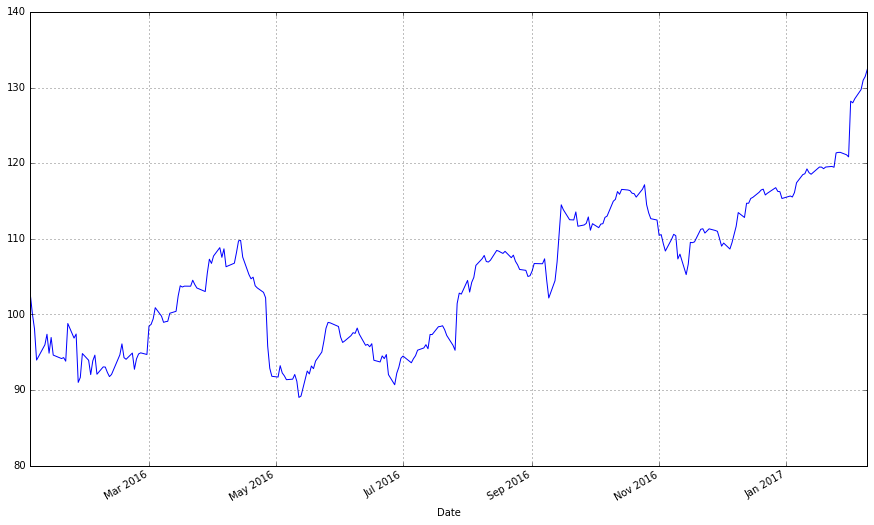

In [5]:
_ = apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

A linechart is fine, but there are at least four variables involved for each date (open, high, low, and close), and we would like to have some visual way to see all four variables that does not require plotting four separate lines. Financial data is often plotted with a Japanese candlestick plot, so named because it was first created by 18th century Japanese rice traders. Such a chart can be created with matplotlib, though it requires considerable effort.

I have made a function you are welcome to use to more easily create candlestick charts from pandas data frames, and use it to plot our stock data. (Code is based off [this example](http://matplotlib.org/examples/pylab_examples/finance_demo.html), and you can read the documentation for the functions involved [here](http://matplotlib.org/api/finance_api.html).)

In [6]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

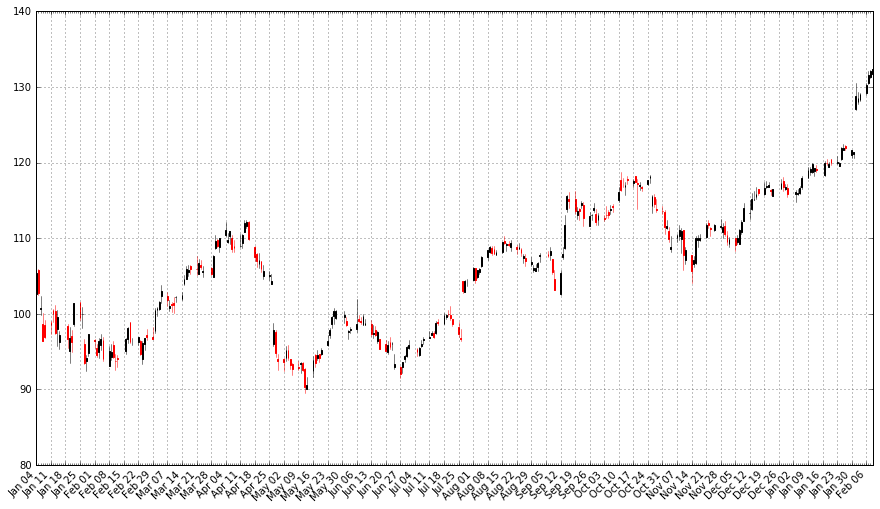

In [7]:
pandas_candlestick_ohlc(apple)

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close). Candlestick charts are popular in finance and some strategies in technical analysis use them to make trading decisions, depending on the shape, color, and position of the candles. I will not cover such strategies today.

We may wish to plot multiple financial instruments together; we may want to compare stocks, compare them to the market, or look at other securities such as exchange-traded funds (ETFs). Later, we will also want to see how to plot a financial instrument against some indicator, like a moving average. For this you would rather use a line chart than a candlestick chart. (How would you plot multiple candlestick charts on top of one another without cluttering the chart?)

Below, I get stock data for some other tech companies and plot their adjusted close together.

In [8]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})   #.reset_index()
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,102.612183,741.840027,53.336436
2016-01-05,100.040792,742.580017,53.579760
2016-01-06,98.083025,743.619995,52.606467
2016-01-07,93.943473,726.390015,50.776676
2016-01-08,94.440222,714.469971,50.932406


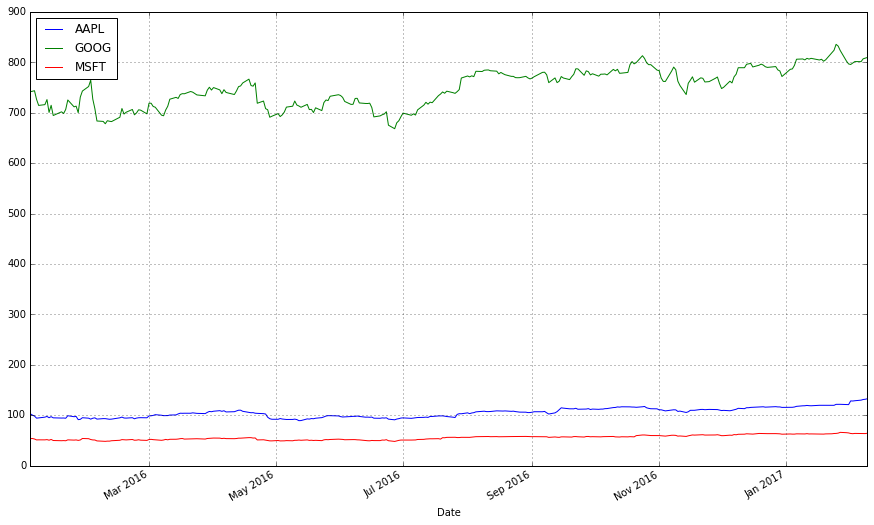

In [9]:
_ = stocks.plot(grid = True)

What’s wrong with this chart? While absolute price is important (pricy stocks are difficult to purchase, which affects not only their volatility but your ability to trade that stock), when trading, we are more concerned about the relative change of an asset rather than its absolute price. Google’s stocks are much more expensive than Apple’s or Microsoft’s, and this difference makes Apple’s and Microsoft’s stocks appear much less volatile than they truly are.

One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

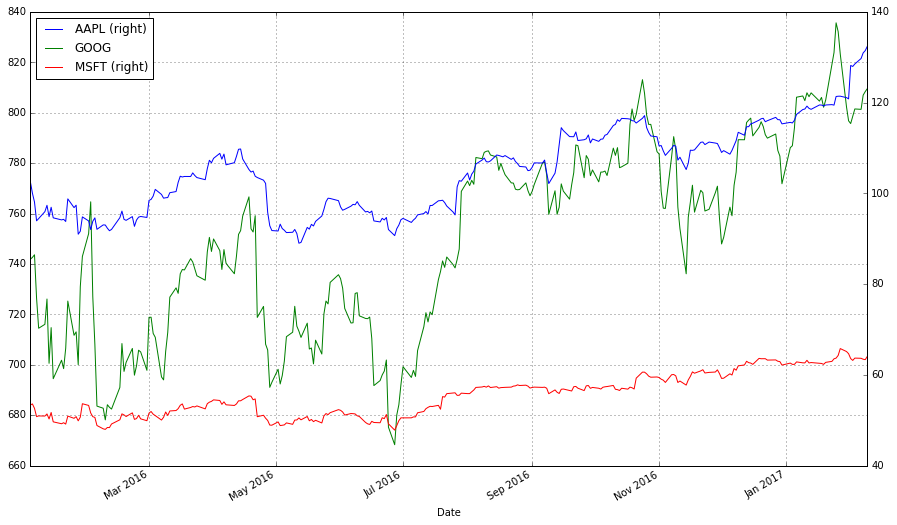

In [10]:
_ = stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply.

One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:

$ return_{t,0} = \frac{price_t}{price_0} $

This will require transforming the data in the stocks object, which I do next.

In [11]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


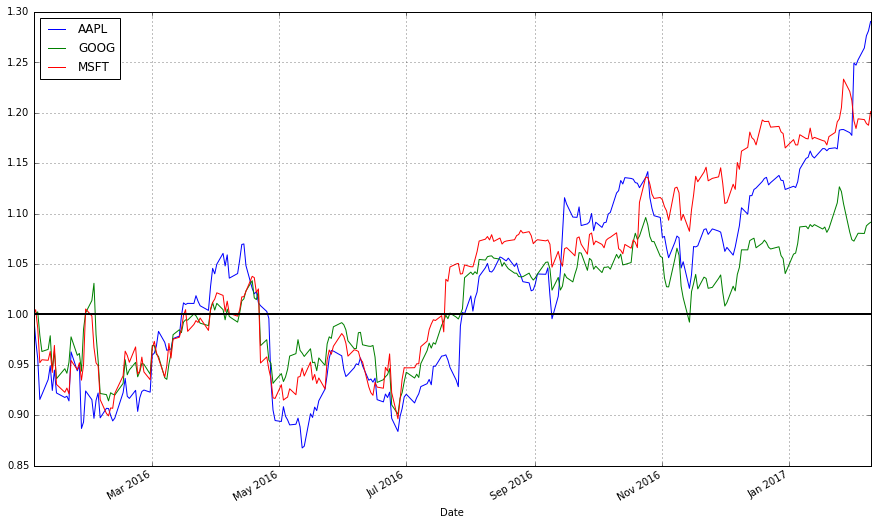

In [12]:
_ = stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts.

Alternatively, we could plot the change of each stock per day. One way to do so would be to plot the percentage increase of a stock when comparing day $t$ to day $t + 1$, with the formula:
    
$ growth_t = \frac{price_{t+1} - price_t}{price_t} $

But change could be thought of differently as:
    
$ increase_t = \frac{price_t - price_{t-1}}{price_t} $

These formulas are not the same and can lead to differing conclusions, but there is another way to model the growth of a stock: with log differences.
    
$ change_t = log(price_t) - log(price_{t-1}) $

The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction.

We can obtain and plot the log differences of the data in stocks as follows:
    


In [13]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


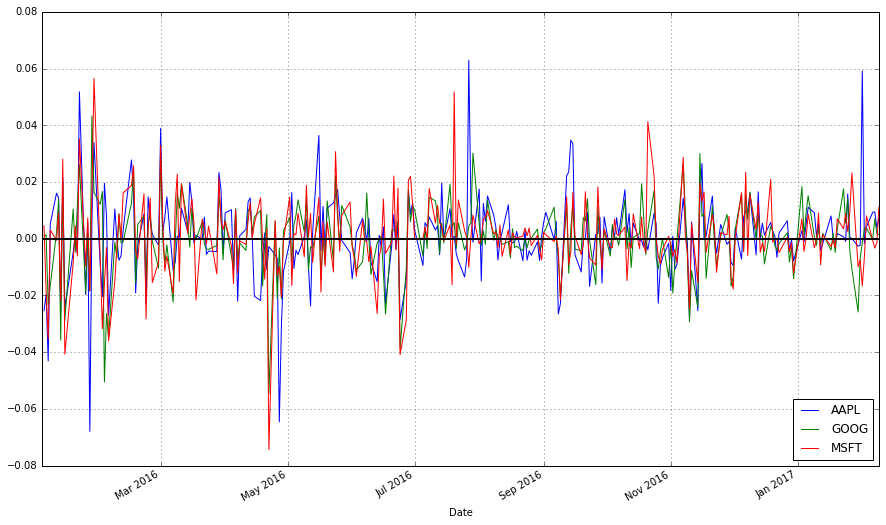

In [14]:
_ = stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Which transformation do you prefer? Looking at returns since the beginning of the period make the overall trend of the securities in question much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

### Moving Averages

Charts are very useful. In fact, some traders base their strategies almost entirely off charts (these are the “technicians”, since trading strategies based off finding patterns in charts is a part of the trading doctrine known as technical analysis). Let’s now consider how we can find trends in stocks.

A q-day moving average is, for a series $ x_t $ and a point in time t, the average of the past $ q $ days: that is, if $ MA^q_t $ denotes a moving average process, then:

$ MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}  $

Moving averages smooth a series and helps identify trends. The larger $q$ is, the less responsive a moving average process is to short-term fluctuations in the series $x_t$. The idea is that moving average processes help identify trends from “noise”. Fast moving averages have smaller $q$ and more closely follow the stock, while slow moving averages have larger $q$, resulting in them responding less to the fluctuations of the stock and being more stable.

**pandas** provides functionality for easily computing moving averages. I demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

D:\Anaconda2\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


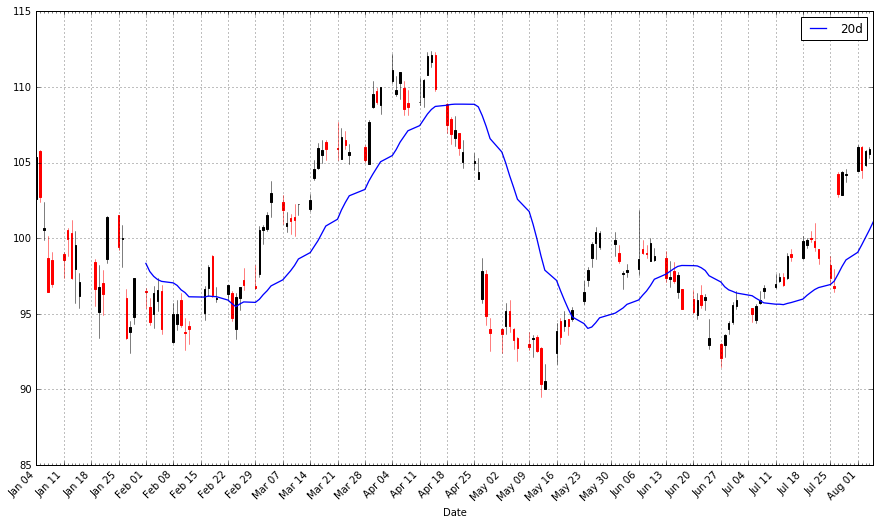

In [15]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
_ = pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

Notice how late the rolling average begins. It cannot be computed until 20 days have passed. This limitation becomes more severe for longer moving averages. Because I would like to be able to compute 200-day moving averages, I’m going to extend out how much AAPL data we have. That said, we will still largely focus on 2016.

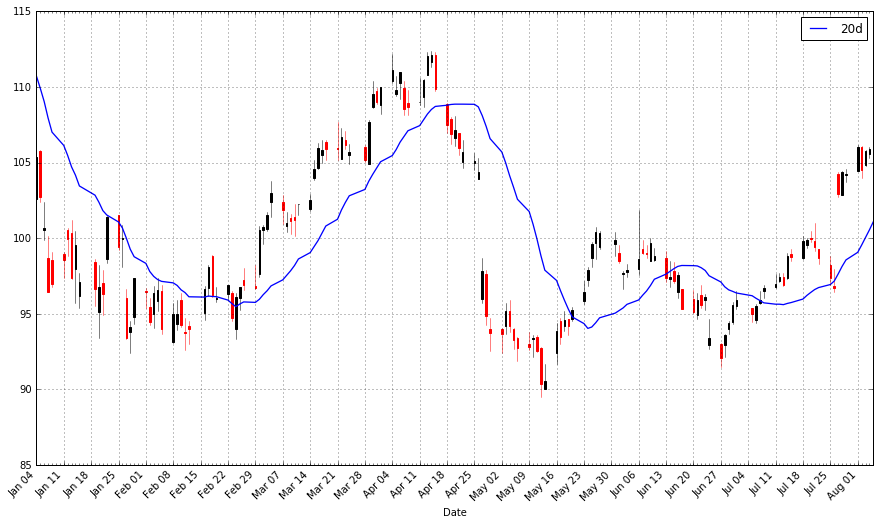

In [16]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

You will notice that a moving average is much smoother than the actua stock data. Additionally, it’s a stubborn indicator; a stock needs to be above or below the moving average line in order for the line to change direction. Thus, crossing a moving average signals a possible change in trend, and should draw attention.

Traders are usually interested in multiple moving averages, such as the 20-day, 50-day, and 200-day moving averages. It’s easy to examine multiple moving averages at once.

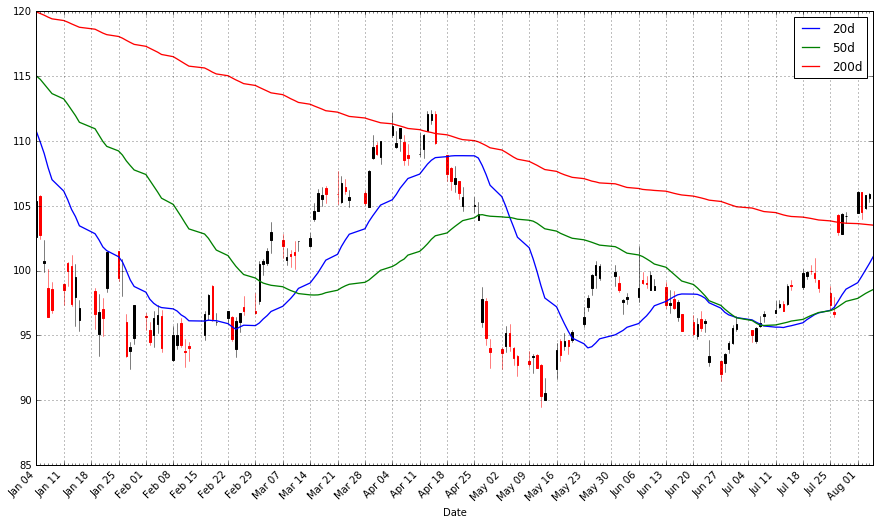

In [17]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

The 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bearish trend: the stock is trending downward over time. The 20-day moving average is at times bearish and at other times bullish, where a positive swing is expected. You can also see that the crossing of moving average lines indicate changes in trend. These crossings are what we can use as trading signals, or indications that a financial security is changing direction and a profitable trade might be made.

### Trading Strategy

Call an open position a trade that will be terminated in the future when a condition is met. A long position is one in which a profit is made if the financial instrument traded increases in value, and a short position is on in which a profit is made if the financial asset being traded decreases in value. When trading stocks directly, all long positions are bullish and all short position are bearish. That said, a bullish attitude need not be accompanied by a long position, and a bearish attitude need not be accompanied by a short position (this is particularly true when trading stock options).

Here is an example. Let’s say you buy a stock with the expectation that the stock will increase in value, with a plan to sell the stock at a higher price. This is a long position: you are holding a financial asset for which you will profit if the asset increases in value. Your potential profit is unlimited, and your potential losses are limited by the price of the stock since stock prices never go below zero. On the other hand, if you expect a stock to decrease in value, you may borrow the stock from a brokerage firm and sell it, with the expectation of buying the stock back later at a lower price, thus earning you a profit. This is called shorting a stock, and is a short position, since you will earn a profit if the stock drops in value. The potential profit from shorting a stock is limited by the price of the stock (the best you can do is have the stock become worth nothing; you buy it back for free), while the losses are unlimited, since you could potentially spend an arbitrarily large amount of money to buy the stock back. Thus, a broker will expect an investor to be in a very good financial position before allowing the investor to short a stock.
    
Any trader must have a set of rules that determine how much of her money she is willing to bet on any single trade. For example, a trader may decide that under no circumstances will she risk more than 10% of her portfolio on a trade. Additionally, in any trade, a trader must have an exit strategy, a set of conditions determining when she will exit the position, for either profit or loss. A trader may set a target, which is the minimum profit that will induce the trader to leave the position. Likewise, a trader must have a maximum loss she is willing to tolerate; if potential losses go beyond this amount, the trader will exit the position in order to prevent any further loss (this is usually done by setting a stop-loss order, an order that is triggered to prevent further losses).

We will call a plan that includes trading signals for prompting trades, a rule for deciding how much of the portfolio to risk on any particular strategy, and a complete exit strategy for any trade an overall trading strategy. Our concern now is to design and evaluate trading strategies.

We will suppose that the amount of money in the portfolio involved in any particular trade is a fixed proportion; 10% seems like a good number. We will also say that for any trade, if losses exceed 20% of the value of the trade, we will exit the position. Now we need a means for deciding when to enter position and when to exit for a profit.

Here, I will be demonstrating a moving average [crossover strategy](http://www.investopedia.com/university/movingaverage/movingaverages4.asp). We will use two moving averages, one we consider “fast”, and the other “slow”. The strategy is:

* Trade the asset when the fast moving average crosses over the slow moving average.
* Exit the trade when the fast moving average crosses over the slow moving average again.

A long trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later. A short trade will be prompted when the fast moving average crosses below the slow moving average, and the trade will be exited when the fast moving average later crosses above the slow moving average.

We now have a complete strategy. But before we decide we want to use it, we should try to evaluate the quality of the strategy first. The usual means for doing so is backtesting, which is looking at how profitable the strategy is on historical data. For example, looking at the above chart’s performance on Apple stock, if the 20-day moving average is the fast moving average and the 50-day moving average the slow, this strategy does not appear to be very profitable, at least not if you are always taking long positions.

Let’s see if we can automate the backtesting task. We first identify when the 20-day average is below the 50-day average, and vice versa.

In [18]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2017-02-03,128.309998,129.190002,128.160004,129.080002,24507300,128.522781,121.45,116.94,107.62,4.51
2017-02-06,129.130005,130.500000,128.899994,130.289993,26845900,129.727549,122.07,117.31,107.75,4.76
2017-02-07,130.539993,132.089996,130.449997,131.529999,38183800,130.962201,122.69,117.72,107.88,4.97
2017-02-08,131.350006,132.220001,131.220001,132.039993,23004100,131.469994,123.34,118.12,108.01,5.22
2017-02-09,131.649994,132.449997,131.119995,132.419998,27991000,132.419998,123.97,118.54,108.15,5.43


We will refer to the sign of this difference as the **regime**; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average. I identify regimes with the following code.

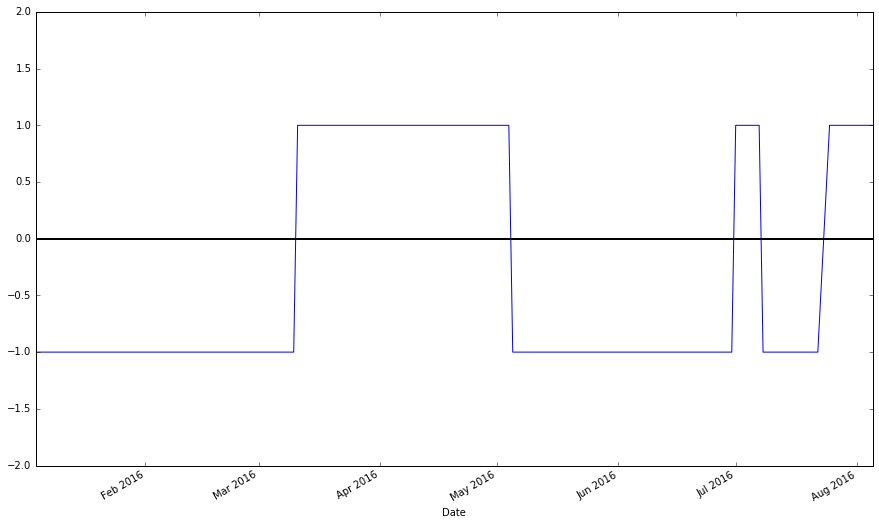

In [19]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
_ = apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

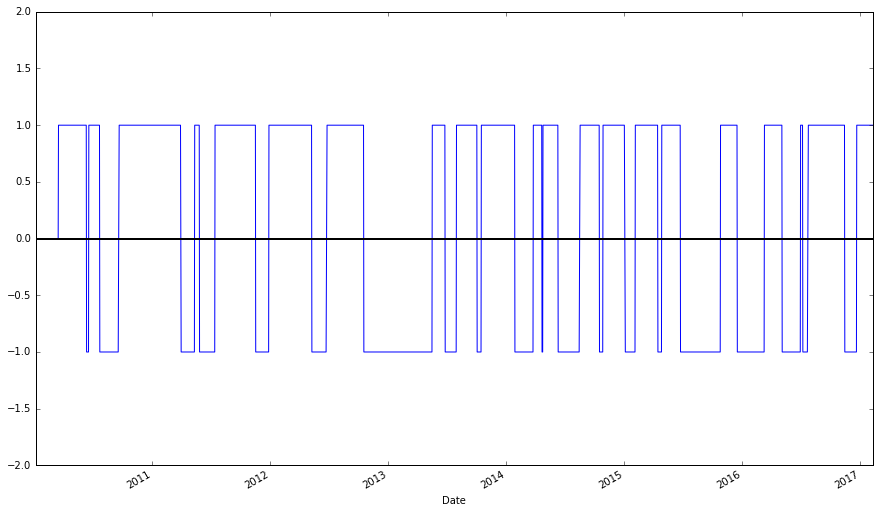

In [20]:
_ = apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [21]:
apple["Regime"].value_counts()

 1    1050
-1     689
 0      50
Name: Regime, dtype: int64

The last line above indicates that for 1005 days the market was bearish on Apple, while for 600 days the market was bullish, and it was neutral for 54 days.

Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

It’s simple to obtain signals. Let $r_t$ indicate the regime at time $t$, and $s_t$ the signal at time $t$. Then:

$ s_t = \text{sign}(r_t - r_{t - 1})  $

$ s_t \in \{-1, 0, 1\}$, with -1 indicating “sell”, 1 indicating “buy”, and 0 no action. We can obtain signals like so:

In [22]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in sign


,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2017-02-03,128.309998,129.190002,128.160004,129.080002,24507300,128.522781,121.45,116.94,107.62,4.51,1.0,0.0
2017-02-06,129.130005,130.500000,128.899994,130.289993,26845900,129.727549,122.07,117.31,107.75,4.76,1.0,0.0
2017-02-07,130.539993,132.089996,130.449997,131.529999,38183800,130.962201,122.69,117.72,107.88,4.97,1.0,0.0
2017-02-08,131.350006,132.220001,131.220001,132.039993,23004100,131.469994,123.34,118.12,108.01,5.22,1.0,0.0
2017-02-09,131.649994,132.449997,131.119995,132.419998,27991000,132.419998,123.97,118.54,108.15,5.43,1.0,-1.0


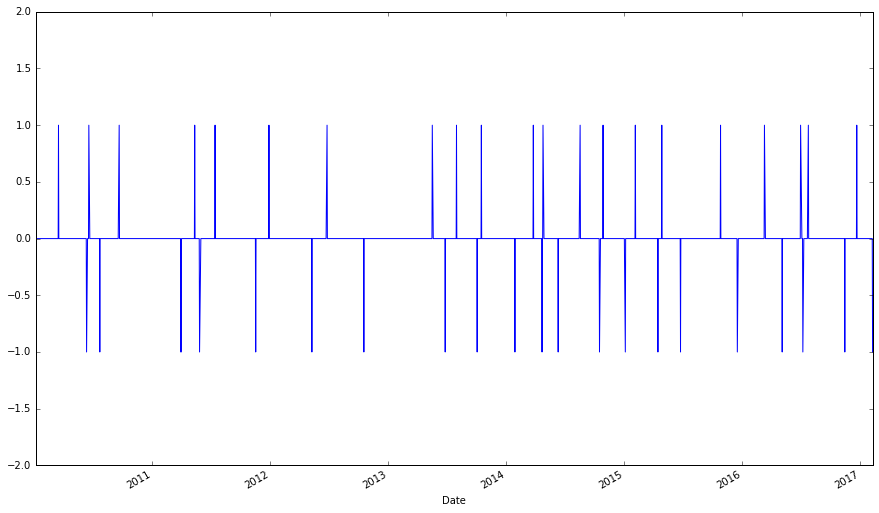

In [23]:
_ = apple["Signal"].plot(ylim = (-2, 2))

In [24]:
apple["Signal"].value_counts()

 0.0    1745
-1.0      22
 1.0      21
Name: Signal, dtype: int64

We would buy Apple stock 23 times and sell Apple stock 23 times. If we only go long on Apple stock, only 23 trades will be engaged in over the 6-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 23 trades total. (Bear in mind that trading more frequently isn’t necessarily good; trades are never free.)

You may notice that the system as it currently stands isn’t very robust, since even a fleeting moment when the fast moving average is above the slow moving average triggers a trade, resulting in trades that end immediately (which is bad if not simply because realistically every trade is accompanied by a fee that can quickly erode earnings). Additionally, every bullish regime immediately transitions into a bearish regime, and if you were constructing trading systems that allow both bullish and bearish bets, this would lead to the end of one trade immediately triggering a new trade that bets on the market in the opposite direction, which again seems finnicky. A better system would require more evidence that the market is moving in some particular direction. But we will not concern ourselves with these details for now.

Let’s now try to identify what the prices of the stock is at every buy and every sell.

In [25]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.449997
2010-06-18    274.070011
2010-09-20    283.230007
2011-05-12    346.569988
2011-07-14    357.770004
2011-12-28    402.640003
2012-06-25    570.770020
2013-05-17    433.260010
2013-07-31    452.529984
2013-10-16    501.110001
2014-03-26    539.779991
2014-04-25    571.939980
2014-08-18     99.160004
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
2016-12-22    116.290001
Name: Close, dtype: float64

In [26]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2010-06-11    253.509995
2010-07-22    259.020000
2011-03-30    348.630009
2011-03-31    348.510006
2011-05-27    337.409992
2011-11-17    377.410000
2012-05-09    569.180023
2012-10-17    644.610001
2013-06-26    398.069992
2013-10-03    483.409996
2014-01-28    506.499977
2014-04-22    531.700020
2014-06-11     93.860001
2014-10-17     97.669998
2015-01-05    106.250000
2015-04-16    126.169998
2015-06-25    127.500000
2015-12-18    106.029999
2016-05-05     93.239998
2016-07-08     96.680000
2016-11-15    107.110001
2017-02-09    132.419998
Name: Close, dtype: float64

In [27]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,224.449997,1.0,Buy
2010-06-11,253.509995,-1.0,Sell
2010-06-18,274.070011,1.0,Buy
2010-07-22,259.020000,-1.0,Sell
2010-09-20,283.230007,1.0,Buy
2011-03-30,348.630009,0.0,Sell
2011-03-31,348.510006,-1.0,Sell
2011-05-12,346.569988,1.0,Buy
2011-05-27,337.409992,-1.0,Sell


In [28]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-11,224.449997,29.059998
2010-06-18,2010-07-22,274.070011,-15.050011
2010-09-20,2011-03-30,283.230007,65.400002
2011-05-12,2011-05-27,346.569988,-9.159996
2011-07-14,2011-11-17,357.770004,19.639996
2011-12-28,2012-05-09,402.640003,166.540020
2012-06-25,2012-10-17,570.770020,73.839981
2013-05-17,2013-06-26,433.260010,-35.190018
2013-07-31,2013-10-03,452.529984,30.880012


Above, we can see that on May 17th, 2013, there was a massive drop in the price of Apple stock, and it looks like our trading system would do badly. But this price drop is not because of a massive shock to Apple, but simply due to a stock split. And while dividend payments are not as obvious as a stock split, they may be affecting the performance of our system.

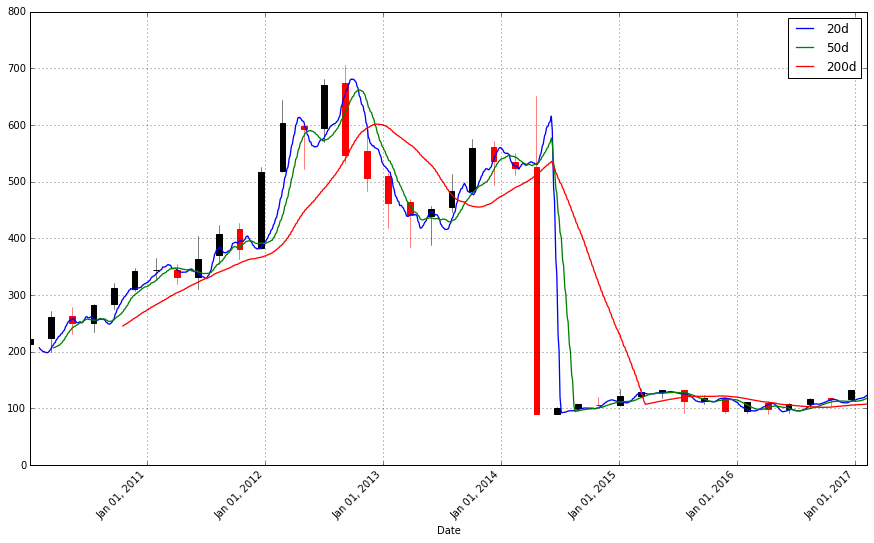

In [29]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

We don’t want our trading system to be behaving poorly because of stock splits and dividend payments. How should we handle this? One approach would be to obtain historical stock split and dividend payment data and design a trading system for handling these. This would most realistically represent the behavior of the stock and could be considered the best solution, but it is more complicated. Another solution would be to adjust the prices to account for stock splits and dividend payments.

Yahoo! Finance only provides the adjusted closing price of a stock, but this is all we need to get adjusted opening, high, and low prices. The adjusted close is computed like so:

$ \text{price}^{\text{adj}}_t = m_t \times \text{price}_t $

where $m_t$ is the multiplier used for the adjustment. Solving for $m_t$ requires only division and thus we can use the closing price and the adjusted closing price to adjust all prices in the series.

Let’s go back, adjust the apple data, and reevaluate our trading system using the adjusted data.

In [30]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in sign


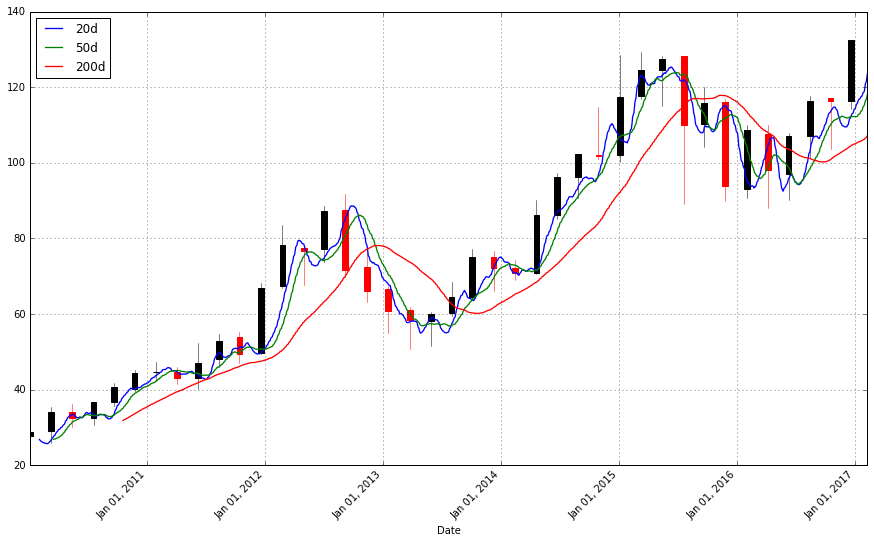

In [31]:
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })

pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [32]:
apple_adj_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-10,29.079641,3.376323
2010-06-18,2010-07-21,35.508388,-2.569168
2010-09-20,2011-03-30,36.695153,8.473194
2011-05-12,2011-05-27,44.901452,-1.186765
2011-07-14,2011-11-17,46.352521,2.544549
2011-12-28,2012-05-09,52.165858,21.576850
2012-06-25,2012-10-17,73.948707,9.925249
2013-05-17,2013-06-26,57.338536,-4.657121
2013-07-31,2013-10-04,59.888765,4.458515


As you can see, adjusting for dividends and stock splits makes a big difference. We will use this data from now on.

Let’s now create a simulated portfolio of $1,000,000, and see how it would behave, according to the rules we have established. This includes:

* Investing only 10% of the portfolio in any trade
* Exiting the position if losses exceed 20% of the value of the trade.

When simulating, bear in mind that:

* Trades are done in batches of 100 stocks.
* Our stop-loss rule involves placing an order to sell the stock the moment the price drops below the specified level. Thus we need to check whether the lows during this period ever go low enough to trigger the stop-loss. Realistically, unless we buy a put option, we cannot guarantee that we will sell the stock at the price we set at the stop-loss, but we will use this as the selling price anyway for the sake of simplicity.
* Every trade is accompanied by a commission to the broker, which should be accounted for. I do not do so here.

Here’s how a backtest may look:

In [33]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-16,2010-06-10,29.079641,3.376323,25.814740
2010-06-18,2010-07-21,35.508388,-2.569168,31.042470
2010-09-20,2011-03-30,36.695153,8.473194,35.628875
2011-05-12,2011-05-27,44.901452,-1.186765,42.679509
2011-07-14,2011-11-17,46.352521,2.544549,45.737111
2011-12-28,2012-05-09,52.165858,21.576850,51.889895
2012-06-25,2012-10-17,73.948707,9.925249,73.280179
2013-05-17,2013-06-26,57.338536,-4.657121,52.362472
2013-07-31,2013-10-04,59.888765,4.458515,59.478506


In [34]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-16,2010-06-10,1.011479e+06,3.376323,29.079641,3400.0,1.000000e+06,0.0,11479.4982,98870.7794
2010-06-18,2010-07-21,1.004286e+06,-2.569168,35.508388,2800.0,1.011479e+06,0.0,-7193.6704,99423.4864
2010-09-20,2011-03-30,1.027163e+06,8.473194,36.695153,2700.0,1.004286e+06,0.0,22877.6238,99076.9131
2011-05-12,2011-05-27,1.024553e+06,-1.186765,44.901452,2200.0,1.027163e+06,0.0,-2610.8830,98783.1944
2011-07-14,2011-11-17,1.030151e+06,2.544549,46.352521,2200.0,1.024553e+06,0.0,5598.0078,101975.5462
2011-12-28,2012-05-09,1.071147e+06,21.576850,52.165858,1900.0,1.030151e+06,0.0,40996.0150,99115.1302
2012-06-25,2012-10-17,1.085042e+06,9.925249,73.948707,1400.0,1.071147e+06,0.0,13895.3486,103528.1898
2013-05-17,2013-06-26,1.076659e+06,-4.657121,57.338536,1800.0,1.085042e+06,0.0,-8382.8178,103209.3648
2013-07-31,2013-10-04,1.084239e+06,4.458515,59.888765,1700.0,1.076659e+06,0.0,7579.4755,101810.9005
2013-10-16,2014-01-28,1.086018e+06,1.111968,66.755822,1600.0,1.084239e+06,0.0,1779.1488,106809.3152


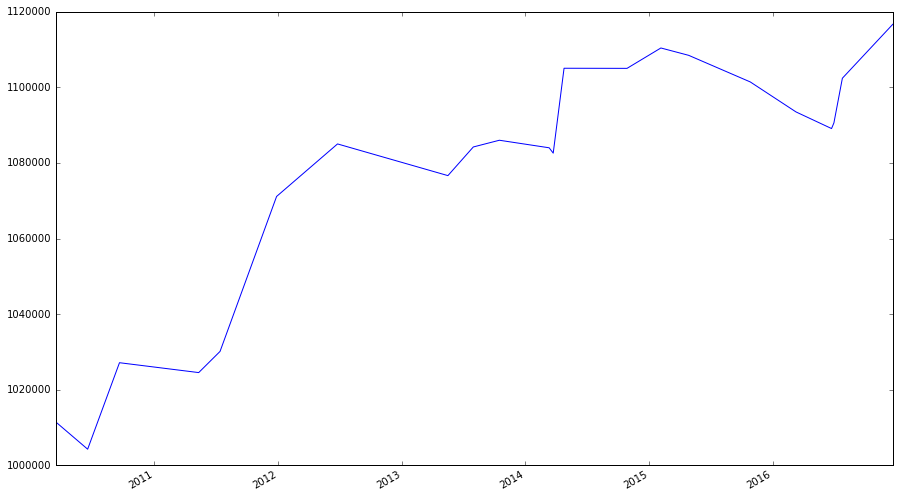

In [35]:
_ = apple_backtest["End Port. Value"].plot()

Our portfolio’s value grew by 10% in about six years. Considering that only 10% of the portfolio was ever involved in any single trade, this is not bad performance.

Notice that this strategy never lead to our stop-loss order being triggered. Does this mean we don’t need stop-loss orders? There is no simple answer to this. After all, if we had chosen a different level at which a stop-loss would be triggered, we may have seen it triggered.

Stop-loss orders are automatically triggered and ask no question as to why the order was triggered. This means that both a genuine change in trend or a momentary fluctuation can trigger a stop-loss, with the latter being the more concerning reason since not only do you have to pay for the order, there is no guarantee that you will sell the stock at the price you set, which could make your losses worse. Meanwhile, the trend on which you based your trade still holds, and had the stop-loss not been triggered, you may have made a profit. That said, a stop-loss can help you protect against your own emotions, staying wedded to a trade even though it has lost its value. They’re also good to have if you cannot monitor or quickly access your portfolio, like when you are on vacation.

I have provided links both [for](http://www.investopedia.com/articles/stocks/09/use-stop-loss.asp) and [“against”](http://www.marketwatch.com/story/why-i-stopped-using-stop-loss-orders-2013-05-09) the use of stop-loss orders, but from now on I’m not going to require our backtesting system to account for them. While less realistic (and I do believe an industrial-strength system should account for a stop-loss rule), this simplifies the backtesting task.

A more realistic portfolio would not be betting 10% of its value on only one stock. A more realistic one would consider investing in multiple stocks. Multiple trades may be ongoing at any given time involving multiple companies, and most of the portfolio will be in stocks, not cash. Now that we will be investing in multiple stops and exiting only when moving averages cross (not because of a stop-loss), we will need to change our approach to backtesting. For example, we will be using one pandas DataFrame to contain all buy and sell orders for all stocks being considered, and our loop above will have to track more information.

I have written functions for creating order data for multiple stocks, and a function for performing the backtesting.

In [36]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades

In [37]:
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results

In [38]:
# Get more stocks
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
facebook = web.DataReader("FB", "yahoo", start, end)
twitter = web.DataReader("TWTR", "yahoo", start, end)
netflix = web.DataReader("NFLX", "yahoo", start, end)
amazon = web.DataReader("AMZN", "yahoo", start, end)
yahoo = web.DataReader("YHOO", "yahoo", start, end)
sony = web.DataReader("SNY", "yahoo", start, end)
nintendo = web.DataReader("NTDOY", "yahoo", start, end)
ibm = web.DataReader("IBM", "yahoo", start, end)
hp = web.DataReader("HPQ", "yahoo", start, end)

In [39]:
signals = ma_crossover_orders([("AAPL", ohlc_adj(apple)),
                              ("MSFT",  ohlc_adj(microsoft)),
                              ("GOOG",  ohlc_adj(google)),
                              ("FB",    ohlc_adj(facebook)),
                              ("TWTR",  ohlc_adj(twitter)),
                              ("NFLX",  ohlc_adj(netflix)),
                              ("AMZN",  ohlc_adj(amazon)),
                              ("YHOO",  ohlc_adj(yahoo)),
                              ("SNY",   ohlc_adj(yahoo)),
                              ("NTDOY", ohlc_adj(nintendo)),
                              ("IBM",   ohlc_adj(ibm)),
                              ("HPQ",   ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in sign


Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     29.079641     1.0    Buy
           AMZN    131.789993     1.0    Buy
           GOOG    282.318173    -1.0   Sell
           HPQ      20.366572     1.0    Buy
           IBM     108.709663     1.0    Buy
           MSFT     24.511988    -1.0   Sell
           NFLX     10.090000     1.0    Buy
           NTDOY    37.099998     1.0    Buy
           SNY      16.360001    -1.0   Sell
           YHOO     16.360001    -1.0   Sell
2010-03-17 SNY      16.500000     1.0    Buy
           YHOO     16.500000     1.0    Buy
2010-03-22 GOOG    278.472004     1.0    Buy
2010-03-23 MSFT     24.937629     1.0    Buy
2010-05-03 GOOG    265.035411    -1.0   Sell
2010-05-10 HPQ      19.102171    -1.0   Sell
2010-05-14 NTDOY    35.799999    -1.0   Sell
2010-05-17 SNY      16.270000    -1.0   Sell
           YHOO     16.270000    -1.0   Sell
2010-05-19 AMZN    124.589996    -1.0   Sell
           MSFT     23.675248    -1.0   Sell
2010-05-21 IBM     106.506978    -1.0   Sell
2010-06-10 AAPL     32.455964     0.0   Sell
2010-06-11 AAPL     32.844641    -1.0   Sell
2010-06-18 AAPL     35.508388     1.0    Buy
2010-06-28 IBM     109.530137     1.0    Buy
2010-07-01 IBM     104.086752    -1.0   Sell
2010-07-06 IBM     104.842542     1.0    Buy
2010-07-09 NTDOY    36.950001     1.0    Buy
2010-07-20 IBM     107.466581    -1.0   Sell
...                       ...     ...    ...
2016-11-01 HPQ      14.229053    -1.0   Sell
2016-11-08 FB      124.220001    -1.0   Sell
2016-11-10 AMZN    742.380005    -1.0   Sell
2016-11-15 AAPL    106.647621    -1.0   Sell
2016-11-18 GOOG    760.539978    -1.0   Sell
           HPQ      15.736241     1.0    Buy
           IBM     159.131761     1.0    Buy
2016-12-12 NTDOY    32.090000     1.0    Buy
           TWTR     18.930000     1.0    Buy
2016-12-21 AAPL    116.554665     1.0    Buy
           NTDOY    25.730000    -1.0   Sell
2016-12-23 GOOG    789.909973     1.0    Buy
2016-12-29 TWTR     16.389999    -1.0   Sell
2017-01-09 AMZN    796.919983     1.0    Buy
2017-01-10 HPQ      14.690000    -1.0   Sell
2017-01-12 FB      126.620003     1.0    Buy
2017-01-20 SNY      42.049999     1.0    Buy
           YHOO     42.049999     1.0    Buy
2017-02-09 AAPL    132.419998     1.0   Sell
           AMZN    821.359985     1.0   Sell
           FB      134.139999     1.0   Sell
           GOOG    809.559998     1.0   Sell
           HPQ      15.640000    -1.0    Buy
           IBM     177.210007     1.0   Sell
           MSFT     64.059998     1.0   Sell
           NFLX    144.139999     1.0   Sell
           NTDOY    26.040001    -1.0    Buy
           SNY      45.080002     1.0   Sell
           TWTR     16.410000    -1.0    Buy
           YHOO     45.080002     1.0   Sell

[507 rows x 3 columns]

In [40]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2010-03-16 AAPL    9.011292e+05     1.000000e+06          0.000000   
           AMZN    8.088762e+05     1.000000e+06          0.000000   
           GOOG    8.088762e+05     1.000000e+06          0.000000   
           HPQ     7.090800e+05     1.000000e+06          0.000000   
           IBM     6.112413e+05     1.000000e+06          0.000000   
           MSFT    6.112413e+05     1.000000e+06          0.000000   
           NFLX    5.113503e+05     1.000000e+06          0.000000   
           NTDOY   4.148903e+05     1.000000e+06          0.000000   
           SNY     4.148903e+05     1.000000e+06          0.000000   
           YHOO    4.148903e+05     1.000000e+06          0.000000   
2010-03-17 SNY     3.158903e+05     1.000000e+06          0.000000   
           YHOO    2.168903e+05     1.000000e+06          0.000000   
2010-03-22 GOOG    1.333487e+05     1.000000e+06          0.000000   
2010-03-23 MSFT    3.359821e+04     1.000000e+06          0.000000   
2010-05-03 GOOG    1.131088e+05     9.959690e+05        -13.436593   
2010-05-10 HPQ     2.067095e+05     9.897735e+05         -1.264401   
2010-05-14 NTDOY   2.997895e+05     9.863935e+05         -1.299999   
2010-05-17 SNY     3.974095e+05     9.850135e+05         -0.230000   
           YHOO    4.950295e+05     9.836335e+05         -0.230000   
2010-05-19 AMZN    5.822425e+05     9.785935e+05         -7.199997   
           MSFT    6.769435e+05     9.735439e+05         -1.262381   
2010-05-21 IBM     7.727997e+05     9.715615e+05         -2.202685   
2010-06-10 AAPL    8.831500e+05     9.830410e+05          3.376323   
2010-06-11 AAPL    8.831500e+05     9.830410e+05          3.765000   
2010-06-18 AAPL    7.872774e+05     9.830410e+05          0.000000   
2010-06-28 IBM     6.996533e+05     9.830410e+05          0.000000   
2010-07-01 IBM     7.829227e+05     9.786863e+05         -5.443385   
2010-07-06 IBM     6.885644e+05     9.786863e+05          0.000000   
2010-07-09 NTDOY   5.924944e+05     9.786863e+05          0.000000   
2010-07-20 IBM     6.892143e+05     9.810479e+05          2.624039   
...                         ...              ...               ...   
2016-11-01 HPQ     9.216171e+05     1.989563e+06          0.897659   
2016-11-08 FB      1.107947e+06     1.993448e+06          2.590004   
2016-11-10 AMZN    1.330661e+06     2.048330e+06        182.940003   
2016-11-15 AAPL    1.533292e+06     2.068740e+06         10.742433   
2016-11-18 GOOG    1.685400e+06     2.063660e+06        -25.400024   
           HPQ     1.479255e+06     2.063660e+06          0.000000   
           IBM     1.288297e+06     2.063660e+06          0.000000   
2016-12-12 NTDOY   1.082921e+06     2.063660e+06          0.000000   
           TWTR    8.765837e+05     2.063660e+06          0.000000   
2016-12-21 AAPL    6.784408e+05     2.063660e+06          0.000000   
           NTDOY   8.431128e+05     2.022956e+06         -6.360000   
2016-12-23 GOOG    6.851308e+05     2.022956e+06          0.000000   
2016-12-29 TWTR    8.637818e+05     1.995270e+06         -2.540001   
2017-01-09 AMZN    7.043978e+05     1.995270e+06          0.000000   
2017-01-10 HPQ     8.968368e+05     1.981565e+06         -1.046241   
2017-01-12 FB      7.069068e+05     1.981565e+06          0.000000   
2017-01-20 SNY     5.092718e+05     1.981565e+06          0.000000   
           YHOO    3.116368e+05     1.981565e+06          0.000000   
2017-02-09 AAPL    5.367508e+05     2.008536e+06         15.865333   
           AMZN    7.010228e+05     2.013424e+06         24.440002   
           FB      9.022328e+05     2.024704e+06          7.519996   
           GOOG    1.064145e+06     2.028634e+06         19.650025   
           HPQ     1.064145e+06     2.028634e+06         -0.096241   
           IBM     1.276797e+06     2.050328e+06         18.078246   
           MSFT    1.488195e+06  

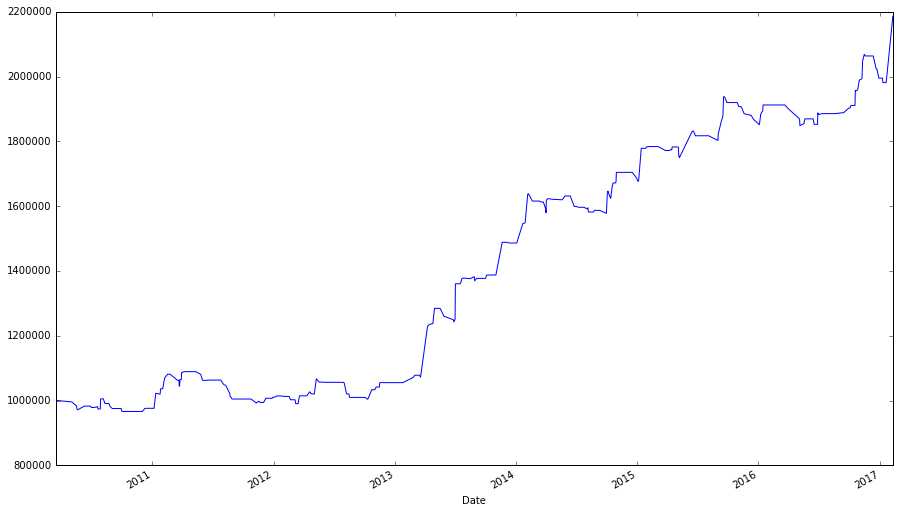

In [41]:
_ = bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

A more realistic portfolio that can invest in any in a list of twelve (tech) stocks has a final growth of about 100%. How good is this? While on the surface not bad, we will see we could have done better.

## Benchmarking

Backtesting is only part of evaluating the efficacy of a trading strategy. We would like to benchmark the strategy, or compare it to other available (usually well-known) strategies in order to determine how well we have done.

Whenever you evaluate a trading system, there is one strategy that you should always check, one that beats all but a handful of managed mutual funds and investment managers: buy and hold [SPY](https://finance.yahoo.com/quote/SPY). The efficient market hypothesis claims that it is all but impossible for anyone to beat the market. Thus, one should always buy an index fund that merely reflects the composition of the market. SPY is an exchange-traded fund (a mutual fund that is traded on the market like a stock) whose value effectively represents the value of the stocks in the S&P 500 stock index. By buying and holding SPY, we are effectively trying to match our returns with the market rather than beat it.

I obtain data on SPY below, and look at the profits for simply buying and holding SPY.

In [42]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,98.214371
2017-02-09,229.240005,230.949997,229.240005,230.600006,63353200,230.600006


In [43]:
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

2337094.9134999998

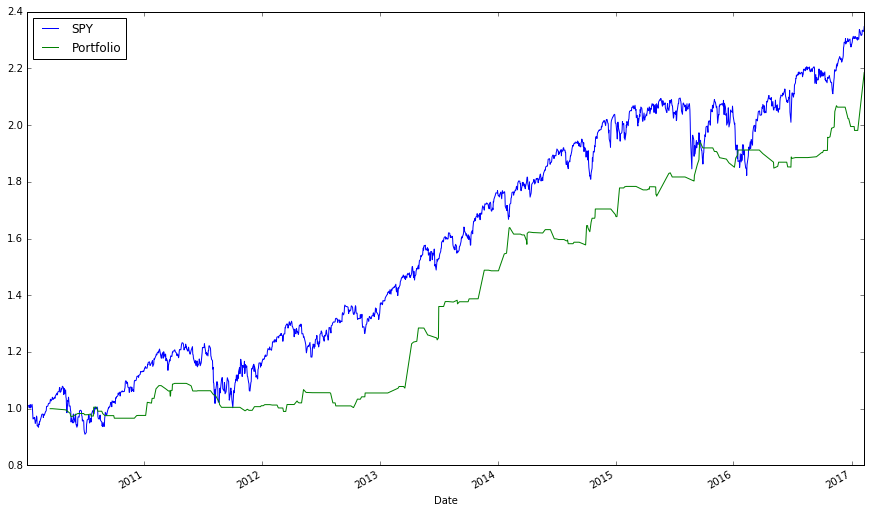

In [44]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench

Buying and holding SPY beats our trading system, at least how we currently set it up, and we haven’t even accounted for how expensive our more complex strategy is in terms of fees. Given both the opportunity cost and the expense associated with the active strategy, we should not use it.

What could we do to improve the performance of our system? For starters, we could try diversifying. All the stocks we considered were tech companies, which means that if the tech industry is doing poorly, our portfolio will reflect that. We could try developing a system that can also short stocks or bet bearishly, so we can take advantage of movement in any direction. We could seek means for forecasting how high we expect a stock to move. Whatever we do, though, must beat this benchmark; otherwise there is an opportunity cost associated with our trading system.

Other benchmark strategies exist, and if our trading system beat the “buy and hold SPY” strategy, we may check against them.